### Connect on email

* Malek Sahlia  - maek.Sahlia@ensi-uma.tn


## 1. Load Essential Libraries

In [46]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

### 2.1. #Load Data and do Fast EDA

In [49]:
#Load the ISEAR Dataset + EDA
df_isear= pd.read_csv('eng_dataset.csv', delimiter=',')
print(df_isear.shape)
df_isear.columns

(7102, 3)


Index(['ID', 'sentiment', 'content'], dtype='object')

In [50]:
df_isear.head(5)

,ID,sentiment,content
0,10941,anger,At the point today where if someone says somet...
1,10942,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,10943,anger,This game has pissed me off more than any othe...
3,10944,anger,@spamvicious I've just found out it's Candice ...
4,10945,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


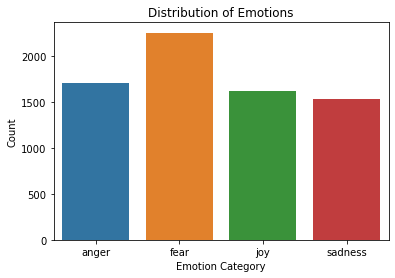

In [54]:
import seaborn as sns

# Distribution of emotions
sns.countplot(x='sentiment', data=df_isear)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.show()

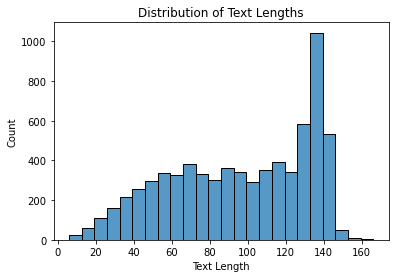

In [55]:
# Distribution of length of texts
text_length = df_isear['content'].apply(len)
sns.histplot(text_length)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

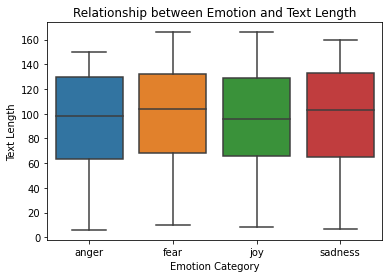

In [56]:
# Relationship between emotion and text length
sns.boxplot(x='sentiment', y=text_length, data=df_isear)
plt.title('Relationship between Emotion and Text Length')
plt.xlabel('Emotion Category')
plt.ylabel('Text Length')
plt.show()

In [65]:
# Load the MELD Dataset + EDA

!wget https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz


'wget' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [60]:
!cat MELD.Raw.tar.gz.* > MELD.Raw.tar.gz
!tar -xvf MELD.Raw.tar.gz


'cat' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [61]:
train_sent_emo=pd.read_csv('train_sent_emo.csv')
test_sent_emo=pd.read_csv('MELD.Raw/test_sent_emo.csv')
dev_sent_emo=pd.read_csv('MELD.Raw/dev_sent_emo.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train_sent_emo.csv'

In [ ]:
print(train_sent_emo.shape)
print(test_sent_emo.shape)
print(dev_sent_emo.shape)

In [ ]:
train_sent_emo.head(5)

In [ ]:
train_sent_emo.columns

In [ ]:
df_train_sent_emo = train_sent_emo[['Utterance', 'Emotion']]
df_test_sent_emo = test_sent_emo[['Utterance', 'Emotion']]
df_dev_sent_emo = dev_sent_emo[['Utterance', 'Emotion']]


In [ ]:
# merge dataframes
merged_MELD = pd.concat([df_train_sent_emo, df_test_sent_emo, df_dev_sent_emo])

In [ ]:
merged_MELD.head(5)

In [ ]:
merged_MELD.columns=['content', 'sentiment']

In [ ]:
# Distribution of emotions
sns.countplot(x='sentiment', data=merged_MELD)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Category')
plt.ylabel('Count')
plt.show()

In [ ]:
# Distribution of length of texts
text_length = merged_MELD['content'].apply(len)
sns.histplot(text_length)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [ ]:
# Relationship between emotion and text length
sns.boxplot(x='sentiment', y=text_length, data=merged_MELD)
plt.title('Relationship between Emotion and Text Length')
plt.xlabel('Emotion Category')
plt.ylabel('Text Length')
plt.show()

In [ ]:
merged_MELD=merged_MELD.loc[:, ::-1]
merged_MELD.head(5)

In [ ]:
df=pd.concat([df_isear[merged_MELD.columns], merged_MELD])

In [ ]:
# write dataframe to CSV file
df.to_csv('df.csv', index=False)

### 2.2. Load Train Data

In [4]:
 # Load data and set labels
data=pd.read_csv('df.csv')

In [66]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

(20810, 2)

In [5]:
data=train_data.copy()
from sklearn.model_selection import train_test_split

X = data.content.values
y = data.sentiment.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [ ]:

test_data.sample(5)

,id,tweet
1539,59336,@AmericanAir flight delayed over 2 hours for n...
607,24101,@SouthwestAir Still getting this error message...
333,13179,waiting at #SeaTac to board my @JetBlue flight...
2696,102948,Hate when I go thru advance seat selection pro...
3585,135638,shame on you @AlaskaAir


## 3. Set up GPU for training

In [6]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayse? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

## 1. Data Preparation

### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [7]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MELEK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [8]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

Wall time: 40.2 s


## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function `get_accuracy_CV` will return the average accuracy score from cross-validation.

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_accuracy_CV(model):
    """
    Return the average accuracy score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get accuracy scores
    acc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="accuracy", cv=kf)

    return acc.mean()


The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV accuracy score.

In [10]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_accuracy_CV(MultinomialNB(alpha=i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))


Best alpha:  0.1


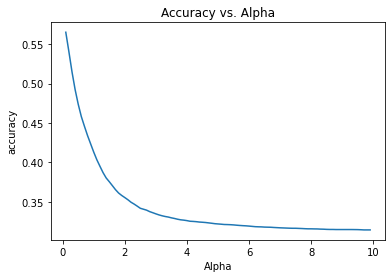

In [11]:
best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('Accuracy vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('accuracy')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [12]:
y_train

array(['fear', 'anger', 'surprise', ..., 'surprise', 'surprise', 'joy'],
      dtype=object)

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def evaluate_roc(probs, y_true):
    """
    Print ROC AUC score for binary and multiclass classification.
    """
    if len(np.unique(y_true)) == 2:
        # binary classification
        roc_auc = roc_auc_score(y_true, probs[:, 1])
        print(f"ROC AUC score: {roc_auc:.3f}")
    else:
        # multiclass classification
        lb = LabelBinarizer()
        lb.fit(y_true)
        y_true_binarized = lb.transform(y_true)
        roc_auc = roc_auc_score(y_true_binarized, probs, average='macro')
        print(f"Macro-averaged ROC AUC score: {roc_auc:.3f}")


By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **79.10%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

In [14]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

Macro-averaged ROC AUC score: 0.791


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [15]:
!pip install transformers==2.8.0

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2f02f4ca408f801bea69b9416ef57a36ba17114941a4a55c079155372e3a7d82
  Stored in directory: c:\users\melek\appdata\local\pip\cache\wheels\12\1c\3d\46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
Failed to build tokenizers


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\MELEK\anaconda3\python.exe' 'C:\Users\MELEK\anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\MELEK\AppData\Local\Temp\tmppdkfm_xu'
       cwd: C:\Users\MELEK\AppData\Local\Temp\pip-install-iik1v7l8\tokenizers_27b83b44ce7345b08b8b929c528e73c0
  Complete output (46 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-39
  creating build\lib.win-amd64-cpython-39\tokenizers
  copying tokenizers\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers
  creating build\lib.win-amd64-cpython-39\tokenizers\models
  copying tokenizers\models\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers\models
  creating build\lib.win-amd64-cpython-39\tokenizers\decoders
  copying tokenizers\decoders\__init__.py -> build\lib.win-amd64-cpython-39\tokenizers\decoders
  creating build\lib.win-amd64-cpython-39\tokenizers\

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [16]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [17]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes
Processed:  At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes


### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [18]:
#!pip install transformers
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

C:\Users\MELEK\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MELEK\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Before tokenizing, we need to specify the maximum length of our sentences.

In [19]:
# Concatenate train data and test data
all_content = data.content.values

# Encode our concatenated data
encoded_content = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_content]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_content])
print('Max length: ', max_len)

Max length:  95


Now let's tokenize our data.

In [20]:
# Specify `MAX_LEN`
MAX_LEN = 64

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes
Token IDs:  [101, 2012, 1996, 2391, 2651, 2073, 2065, 2619, 2758, 2242, 19512, 2785, 2000, 2033, 1010, 1037, 14297, 2097, 6532, 2041, 1997, 2026, 2159, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


C:\Users\MELEK\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to integer values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

train_labels = train_labels.to(torch.long)
val_labels = val_labels.to(torch.long)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [34]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 9

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [35]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [36]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits.type_as(b_labels), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [37]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import random
random.seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.897763   |     -      |     -     |  118.84  
   1    |   40    |   1.574312   |     -      |     -     |  116.91  
   1    |   60    |   1.457511   |     -      |     -     |  126.18  
   1    |   80    |   1.331367   |     -      |     -     |  120.44  
   1    |   100   |   1.310993   |     -      |     -     |  117.95  
   1    |   120   |   1.234024   |     -      |     -     |  128.71  
   1    |   140   |   1.179022   |     -      |     -     |  146.33  
   1    |   160   |   1.084431   |     -      |     -     |  146.33  
   1    |   180   |   1.035216   |     -      |     -     |  145.50  
   1    |   200   |   1.046539   |     -      |     -     |  131.52  
   1    |   220   |   1.039955   |     -      |     -     |  137.34  
   1    |   240   |   1.029548   |     -      |     -     |  137.03  


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [38]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [39]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

IndexError: index 7 is out of bounds for axis 1 with size 7

### 3.5. Train Our Model on the Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

## 4. Predictions on Test Set

### 4.1. Data Preparation

Let's revisit out test set shortly.

In [ ]:
test_data.sample(5)

In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

### 4.2. Predictions

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Now we will examine 20 random tweets from our predictions. 17 of them are correct, showing that the BERT Classifier acquires about 0.85 precision rate.

In [ ]:
output = test_data[preds==1]
list(output.sample(20).tweet)